# Finding Average SEP duration from Onset to Peak

name: 112, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
448         448  2.455423e+06  2010  226.43403    0.12371     0.0000      1   
449         449  2.455423e+06  2010  226.50000   10.05800    95.4760      2   
450         450  2.455423e+06  2010  226.53819   14.60800    11.6040      3   
451         451  2.455423e+06  2010  226.62500    6.19230    -5.1731      4   

               datetime  
448 2010-08-14 10:25:00  
449 2010-08-14 12:00:00  
450 2010-08-14 12:54:00  
451 2010-08-14 15:00:00  
start time: 2010-08-14 10:25:00, peak_time: 2010-08-14 12:54:00
name: 113, group:      Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
452         452  2.455628e+06  2011   66.90278    0.15431     0.0000      1   
453         453  2.455629e+06  2011   67.04861   11.26300    28.6080      2   
454         454  2.455629e+06  2011   67.34028   50.14600     5.0381      3   
455         455  2.455631e+06  2011   69.59722    6.80720 

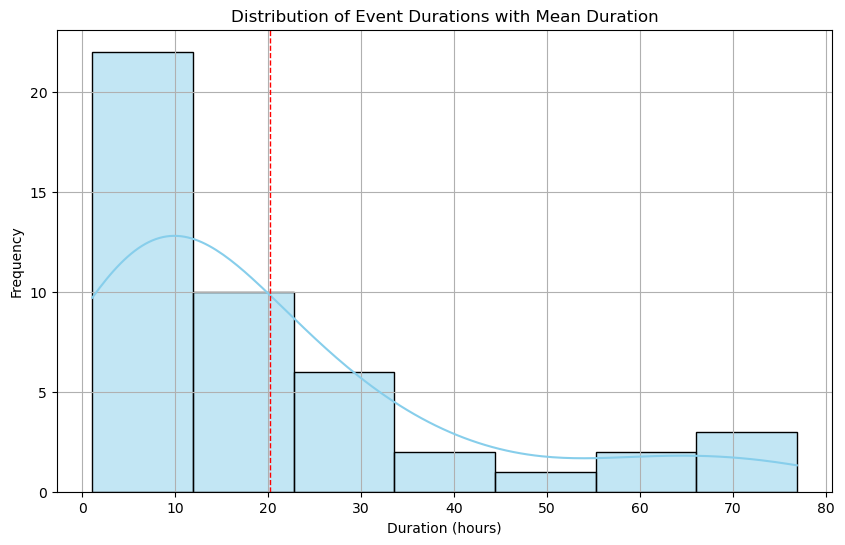

average sep duration: 0 days 20:13:56.086956521, number of seps:46


In [1]:
from dataload.calc_cme_history import calculate_average_duration
import pandas as pd

file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
df = pd.read_csv(file_path)

avg_sep_duration, num_seps = calculate_average_duration(df, start_year=2010, end_year=2017, debug=True)

# print the duration
print(f"average sep duration: {avg_sep_duration}, number of seps:{num_seps}")

# Building the dataset

steps involved in building the dataset. 

identify 46 SEPs and create 46 csv files for each SEP from pf10 file
each csv will have target time, feature time starting from the 

In [3]:
output_dir = "D:/College/Fall2023/electron_cme_data"
sep_file_path = "D:/College/Fall2023/new_data/curr_pf10th10_original.csv"
cme_file_path = "D:/College/Fall2023/new_data/SEP10MeV_Features.csv"
flux_data_path = 'D:/College/Fall2023/new_data/ephin5m.dat'

In [4]:
import pandas as pd

# Load the dataset
file_path_ds1 = sep_file_path
df_ds1 = pd.read_csv(file_path_ds1)

# Display the first few rows to understand its structure
df_ds1.head()


Unnamed: 0    Julian Day  Year  DayOfYear  Intensity  %Rate/day  Index  \
0           0  2.450011e+06  1995  293.26389    0.11119     0.0000      1   
1           1  2.450011e+06  1995  293.34375   10.93500    70.0420      2   
2           2  2.450011e+06  1995  293.51042   65.14900    11.1010      3   
3           3  2.450012e+06  1995  294.10417    6.93270    -4.1139      4   
4           4  2.450757e+06  1997  308.25347    0.16920     0.0000      1   

              datetime  
0  1995-10-20 06:20:00  
1  1995-10-20 08:15:00  
2  1995-10-20 12:15:00  
3  1995-10-21 02:30:00  
4  1997-11-04 06:04:00

In [8]:
def find_sep_times(df, start_year=None, end_year=None):
    """
    Finds the onset time and peak time of each SEP event within a specified start and end year.

    Args:
        df (pd.DataFrame): DataFrame containing the SEP event data.
        start_year (int, optional): The start year for filtering events. Defaults to None.
        end_year (int, optional): The end year for filtering events. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Event', 'Onset Time', 'Peak Time']
    """
    # Convert datetime column to datetime objects
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Filter by year if specified
    if start_year:
        df = df[df['Year'] >= start_year]
    if end_year:
        df = df[df['Year'] <= end_year]

    # Initialize a list to store the event data
    events = []

    # Iterate over the groups (each group should represent an SEP event)
    for event_num, group in enumerate(df.groupby(df.index // 4)):
        group_data = group[1]
        onset_time = group_data[group_data['Index'] == 1]['datetime'].iloc[0]
        peak_time = group_data[group_data['Index'] == 3]['datetime'].iloc[0]
        events.append({'Event': event_num + 1, 'Onset Time': onset_time, 'Peak Time': peak_time})

    # Convert the list to a DataFrame
    sep_times = pd.DataFrame(events)

    return sep_times


In [9]:
# Applying the function to the dataset
sep_times_df = find_sep_times(df_ds1, start_year=2010, end_year=2017)

print(len(sep_times_df))

46


In [23]:
from typing import Dict, List, Optional
from datetime import timedelta
import pandas as pd

def generate_event_time_data(df: pd.DataFrame, 
                             start_year: Optional[int] = None, 
                             end_year: Optional[int] = None) -> Dict[int, Dict[str, List[pd.Timestamp]]]:
    """
    Generates detailed time data for each SEP event, ensuring the peak time is included or just before the last timestep.

    Args:
        df (pd.DataFrame): DataFrame containing the SEP event data.
        start_year (Optional[int], optional): The start year for filtering events. Defaults to None.
        end_year (Optional[int], optional): The end year for filtering events. Defaults to None.

    Returns:
        Dict[int, Dict[str, List[pd.Timestamp]]]: A dictionary with each SEP event's detailed time data.
            Each event (keyed by an integer) maps to another dictionary with keys 'onset_time', 'peak_time', 
            'target_tplus6', and 'feature_t', each mapping to a list of pandas Timestamp objects.
    """
    # Convert datetime column to datetime objects
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Filter by year if specified
    if start_year is not None:
        df = df[df['Year'] >= start_year]
    if end_year is not None:
        df = df[df['Year'] <= end_year]

    # Initialize a dictionary to store the detailed time data for each event
    event_time_data = {}

    # Iterate over the groups (each group should represent an SEP event)
    for event_num, group in enumerate(df.groupby(df.index // 4)):
        group_data = group[1]
        onset_time: pd.Timestamp = group_data[group_data['Index'] == 1]['datetime'].iloc[0]
        peak_time: pd.Timestamp = group_data[group_data['Index'] == 3]['datetime'].iloc[0]

        # Generate time steps from 2 hours before onset to peak, every 5 minutes
        start_time: pd.Timestamp = onset_time - timedelta(hours=2)
        current_time: pd.Timestamp = start_time
        target_tplus6: List[pd.Timestamp] = []
        feature_t: List[pd.Timestamp] = []
        while current_time <= peak_time:
            target_tplus6.append(current_time)
            feature_t.append(current_time - timedelta(minutes=30))
            current_time += timedelta(minutes=5)

        # Check if the last timestep matches with the peak time, if not, add an additional timestep
        if target_tplus6[-1] != peak_time:
            target_tplus6.append(current_time)  # adding one more time step
            feature_t.append(current_time - timedelta(minutes=30))

        # Store the time data for this event
        event_time_data[event_num + 1] = {
            'onset_time': onset_time,
            'peak_time': peak_time,
            'target_tplus6': target_tplus6,
            'feature_t': feature_t
        }

    return event_time_data


In [24]:
# Applying the function to the dataset
event_time_data = generate_event_time_data(df_ds1, start_year=2010, end_year=2017)

In [25]:
# Example: Display the detailed time data for the first event
first_event_data = event_time_data.get(1, {})
first_event_data


{'onset_time': Timestamp('2010-08-14 10:25:00'),
 'peak_time': Timestamp('2010-08-14 12:54:00'),
 'target_tplus6': [Timestamp('2010-08-14 08:25:00'),
  Timestamp('2010-08-14 08:30:00'),
  Timestamp('2010-08-14 08:35:00'),
  Timestamp('2010-08-14 08:40:00'),
  Timestamp('2010-08-14 08:45:00'),
  Timestamp('2010-08-14 08:50:00'),
  Timestamp('2010-08-14 08:55:00'),
  Timestamp('2010-08-14 09:00:00'),
  Timestamp('2010-08-14 09:05:00'),
  Timestamp('2010-08-14 09:10:00'),
  Timestamp('2010-08-14 09:15:00'),
  Timestamp('2010-08-14 09:20:00'),
  Timestamp('2010-08-14 09:25:00'),
  Timestamp('2010-08-14 09:30:00'),
  Timestamp('2010-08-14 09:35:00'),
  Timestamp('2010-08-14 09:40:00'),
  Timestamp('2010-08-14 09:45:00'),
  Timestamp('2010-08-14 09:50:00'),
  Timestamp('2010-08-14 09:55:00'),
  Timestamp('2010-08-14 10:00:00'),
  Timestamp('2010-08-14 10:05:00'),
  Timestamp('2010-08-14 10:10:00'),
  Timestamp('2010-08-14 10:15:00'),
  Timestamp('2010-08-14 10:20:00'),
  Timestamp('2010-08-1

In [27]:
df_ds2 = pd.read_csv(cme_file_path)
# Display the first few rows to understand its structure, focusing on the CME_DONKI_time column
ds2_head = df_ds2.head()

In [33]:
from typing import Dict, List, Optional
from datetime import timedelta
import pandas as pd

def generate_event_time_data(ds1: pd.DataFrame, ds2: pd.DataFrame, 
                             start_year: Optional[int] = None, 
                             end_year: Optional[int] = None) -> Dict[int, Dict[str, List[pd.Timestamp]]]:
    """
    Generates detailed time data for each SEP event in ds1, including CME times from ds2 and additional time keys.

    Args:
        ds1 (pd.DataFrame): DataFrame containing the SEP event data from ds1.
        ds2 (pd.DataFrame): DataFrame containing the CME data from ds2.
        start_year (Optional[int], optional): The start year for filtering events in ds1. Defaults to None.
        end_year (Optional[int], optional): The end year for filtering events in ds1. Defaults to None.

    Returns:
        Dict[int, Dict[str, List[pd.Timestamp]]]: A dictionary with each SEP event's detailed time data.
    """
    # Convert datetime columns to datetime objects
    ds1['datetime'] = pd.to_datetime(ds1['datetime'])
    ds2['CME_DONKI_time'] = pd.to_datetime(ds2['CME_DONKI_time'], format='%m/%d/%Y %H:%M')

    # Filter ds1 by year if specified
    if start_year is not None:
        ds1 = ds1[ds1['Year'] >= start_year]
    if end_year is not None:
        ds1 = ds1[ds1['Year'] <= end_year]

    # Initialize a dictionary to store the detailed time data for each event
    event_time_data: Dict[int, Dict[str, List[pd.Timestamp]]] = {}

    # Iterate over the groups in ds1 (each group should represent an SEP event)
    for event_num, group in enumerate(ds1.groupby(ds1.index // 4)):
        group_data = group[1]
        onset_time: pd.Timestamp = group_data[group_data['Index'] == 1]['datetime'].iloc[0]
        peak_time: pd.Timestamp = group_data[group_data['Index'] == 3]['datetime'].iloc[0]

        # Generate time steps from 2 hours before onset to peak, every 5 minutes
        start_time: pd.Timestamp = onset_time - timedelta(hours=2)
        current_time: pd.Timestamp = start_time
        target_tplus6: List[pd.Timestamp] = []
        feature_t: List[pd.Timestamp] = []
        while current_time <= peak_time:
            target_tplus6.append(current_time)
            feature_t.append(current_time - timedelta(minutes=30))
            current_time += timedelta(minutes=5)

        # Check if the last timestep matches with the peak time, if not, add an additional timestep
        if target_tplus6[-1] != peak_time:
            target_tplus6.append(current_time)  # adding one more time step
            feature_t.append(current_time - timedelta(minutes=30))

        # Find CMEs from ds2 that fall between the first and last timestep in target_tplus6
        cmes = ds2[(ds2['CME_DONKI_time'] >= target_tplus6[0]) & 
                   (ds2['CME_DONKI_time'] <= target_tplus6[-1])]['CME_DONKI_time'].tolist()

        # Store the time data for this event
        event_dict = {
            'onset_time': onset_time,
            'peak_time': peak_time,
            'target_tplus6': target_tplus6,
            'feature_t': feature_t,
            'cmes': cmes
        }

        # Add additional time keys (tminus24 to tminus1 and t)
        for i in range(24, 0, -1):
            key_name = f'tminus{i}'
            start_times = [time - timedelta(minutes=i*5) for time in feature_t]
            event_dict[key_name] = start_times

        # 't' key is the same as 'feature_t'
        event_dict['t'] = feature_t

        event_time_data[event_num + 1] = event_dict

    return event_time_data


In [34]:
# Applying the function to the dataset
event_time_data2 = generate_event_time_data(df_ds1, df_ds2, start_year=2010, end_year=2017)

In [36]:
# Example: Display the detailed time data for the first event
first_event_data2 = event_time_data2.get(1, {})
first_event_data2

{'onset_time': Timestamp('2010-08-14 10:25:00'),
 'peak_time': Timestamp('2010-08-14 12:54:00'),
 'target_tplus6': [Timestamp('2010-08-14 08:25:00'),
  Timestamp('2010-08-14 08:30:00'),
  Timestamp('2010-08-14 08:35:00'),
  Timestamp('2010-08-14 08:40:00'),
  Timestamp('2010-08-14 08:45:00'),
  Timestamp('2010-08-14 08:50:00'),
  Timestamp('2010-08-14 08:55:00'),
  Timestamp('2010-08-14 09:00:00'),
  Timestamp('2010-08-14 09:05:00'),
  Timestamp('2010-08-14 09:10:00'),
  Timestamp('2010-08-14 09:15:00'),
  Timestamp('2010-08-14 09:20:00'),
  Timestamp('2010-08-14 09:25:00'),
  Timestamp('2010-08-14 09:30:00'),
  Timestamp('2010-08-14 09:35:00'),
  Timestamp('2010-08-14 09:40:00'),
  Timestamp('2010-08-14 09:45:00'),
  Timestamp('2010-08-14 09:50:00'),
  Timestamp('2010-08-14 09:55:00'),
  Timestamp('2010-08-14 10:00:00'),
  Timestamp('2010-08-14 10:05:00'),
  Timestamp('2010-08-14 10:10:00'),
  Timestamp('2010-08-14 10:15:00'),
  Timestamp('2010-08-14 10:20:00'),
  Timestamp('2010-08-1

In [ ]:
# great! we are going to add 24 more keys to our event dictionary called "tminus24", "tminus23", .... to "tminus1" and "t". for each key, we will read ds3, for list of increment of timesteps incrementing by 5 from the timestep of the  and read the value of the 0.5 MeV electron intensity at the timesteps matching "t", "tminus1", ... "tminus24" for each sep

In [ ]:
# great! let's add a start time key which is just the start time timesteps (2 hours before onset time). let's add "nticks" key that is just the length of the common length of  all the list. the function should check print a message if they list indeed have common length matching ntciks or print error otherwise. let's revisit the cmes list and now let's make it a list of size "nticks" shoudl be a copy of feature_t list. Then we will replace all timestamps with zeroes except for the timestamps that start with 